In [1]:
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import alen, arange
import math
from math import sqrt
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

from sklearn.svm import SVR
#### PLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter

In [2]:
#BPSO

def pls_optimise_components(X, y, npc):
 
    rmsecv = np.zeros(npc)
    for i in range(1,npc+1,1):
 
        # Simple PLS
        pls_simple = PLSRegression(n_components=i)
        # Fit
        pls_simple.fit(X, y)
        #cv = LeaveOneOut()
        cv=10
        # Cross-validation
        y_cv = cross_val_predict(pls_simple, X, y, cv=cv)
 
        # Calculate scores
        score = r2_score(y, y_cv)
        rmsecv[i-1] = np.sqrt(mean_squared_error(y, y_cv))
 
    # Find the minimum of ther RMSE and its location
    opt_comp, rmsecv_min = np.argmin(rmsecv),  rmsecv[np.argmin(rmsecv)]
 
    return (opt_comp+1, rmsecv_min)

def base_pls(X,y,n_components, return_model=False):
 
    # Simple PLS
    pls_simple = PLSRegression(n_components=n_components)
    # Fit
    pls_simple.fit(X, y)
    cv = 10
    # Cross-validation
    y_cv = cross_val_predict(pls_simple, X, y, cv=cv)
 
    # Calculate scores
    score = r2_score(y, y_cv)
    rmsecv = np.sqrt(mean_squared_error(y, y_cv))
 
    if return_model == False:
        return(y_cv, score, rmsecv)
    else:
        return(y_cv, score, rmsecv, pls_simple)
    
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# Create an instance 
#reg = linear_model.LinearRegression

# Define objective function
def f_per_particle(m, alpha):
    """Computes for the objective function per particle

    Inputs
    ------
    m : numpy.ndarray
        Binary mask that can be obtained from BinaryPSO, will
        be used to mask features.
    alpha: float (default is 0.5)
        Constant weight for trading-off classifier performance
        and number of features

    Returns
    -------
    numpy.ndarray
        Computed objective function
    """
    
    total_features = dimensions
    # Get the subset of the features from the binary mask

    #X_sav = savgol_filter(X_train, 3, polyorder=2, deriv=1)

    if np.count_nonzero(m) == 0:
        X_subset = X_train
    else:
        X_subset = X_train[:,m==1]

    
 

    # #regr = make_pipeline(StandardScaler(), SVR())
    # #regr = make_pipeline(StandardScaler(), RandomForestRegressor(max_depth=5, random_state=1))
    # #regr = make_pipeline(StandardScaler(), SVR(C = 0.5, degree= 1, kernel= 'rbf',epsilon= 0.16))
    # #X1 = savgol_filter(X_subset, 3, polyorder=2, deriv=1)
    # reg1 = GradientBoostingRegressor(random_state=1)
    # #reg2 = RandomForestRegressor(random_state=1)
    # opt_comp, rmsecv_min = pls_optimise_components(X_subset, y_train_oleo, 8)
    # reg3 = PLSRegression(n_components=opt_comp)
    # #reg3 = PLSRegression(n_components=5)
    # #reg3 = LinearRegression()
    # ereg = VotingRegressor(estimators=[('gb', reg1), ('plsr', reg3)])
    # ereg = ereg.fit(X_subset, y_train_oleo)
    # #regr.fit(X_subset, y_train_oleo)
    # y_pred = cross_val_predict(ereg, X_subset, y_train_oleo, cv=10)
    # #y_pred = ereg.predict(X_subset)
    # #y_pred = regr.predict(X1)
    # #r2cv = mean_squared_error(y_train_oleo, y_pred)
    # r2cv = r2_score(y_train_oleo, y_pred)
    # P = r2cv
    # #P = (classifier.predict(X_subset) == y).mean()
    # # Compute for the objective function
    # j = (alpha * (1.0 - P)
    #     + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))



    opt_comp, rmsecv_min = pls_optimise_components(X_subset, y_train_oleo, 8)
    predicted, r2cv, rmscv = base_pls(X_subset, y_train_oleo, opt_comp)
    
    P = r2cv
    #P = (classifier.predict(X_subset) == y).mean()
    # Compute for the objective function
    j = (alpha * (1.0 - P)
        + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))

    return j

def f(x, alpha=0.88):
    """Higher-level method to do classification in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

def msc(input_data):
     # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
 
    # Get the reference spectrum. If not given, estimate it from the mean    

    # Calculate mean
    ref = np.mean(input_data, axis=0)

 
    # Define a new array and populate it with the corrected data    
    output_data= np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return output_data

In [3]:
pd.set_option('display.max_rows', None)
df = pd.read_csv('Data/Wheat/Wheat_mean_NIR_data_65_samples.csv')

In [4]:
df.head()

,Sample,Batch,Order,TP,CUPRAC,FRAP,TMA,Moisture,Protein,999.8970106,...,2478.712814,2481.08483,2483.461389,2485.842505,2488.227573,2490.617843,2493.012709,2495.412185,2497.816284,2500.22502
0,W1,1,1,177.256315,366.709718,56.286815,0.000000,10.1,13.904338,0.264490,...,0.993593,0.996831,0.998601,1.000223,1.001534,1.001571,1.002851,1.004485,1.004250,1.002066
1,W2,1,2,153.408515,290.123902,53.543083,2.511161,8.7,14.786418,0.283164,...,1.031166,1.033582,1.035195,1.037318,1.038840,1.038373,1.038098,1.039568,1.039971,1.039888
2,W3,1,3,167.788770,433.513709,54.841090,0.235243,10.4,12.500000,0.276600,...,1.048032,1.050699,1.051539,1.053081,1.054179,1.054097,1.053567,1.053987,1.054386,1.052976
3,W4,1,4,161.171271,281.405362,57.062854,9.228084,11.6,14.819005,0.284350,...,1.066802,1.069377,1.071662,1.075393,1.077126,1.075814,1.075846,1.076120,1.076186,1.076950
4,W5,1,5,143.785691,309.539558,55.627153,0.590040,10.9,16.722783,0.294623,...,1.007914,1.010732,1.012537,1.013475,1.015025,1.014866,1.015861,1.016620,1.016702,1.016687


In [5]:
df.describe()

,Batch,Order,TP,CUPRAC,FRAP,TMA,Moisture,Protein,999.8970106,1000.28298,...,2478.712814,2481.08483,2483.461389,2485.842505,2488.227573,2490.617843,2493.012709,2495.412185,2497.816284,2500.22502
count,65.000000,65.00000,65.000000,17.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,...,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,1.738462,33.00000,150.098065,352.708476,31.096655,2.357995,11.851231,14.114709,0.262450,0.263598,...,1.015912,1.018007,1.019769,1.021549,1.023116,1.023843,1.024174,1.024359,1.024523,1.024243
std,0.442893,18.90767,10.953101,48.320131,15.224195,1.977936,1.358467,2.029961,0.013381,0.013966,...,0.032438,0.032584,0.032673,0.032854,0.032833,0.032685,0.032748,0.032733,0.032808,0.032759
min,1.000000,1.00000,129.700000,266.458447,14.400000,0.000000,8.700000,10.664571,0.248124,0.247141,...,0.925526,0.928191,0.927884,0.928114,0.930028,0.930709,0.930913,0.930114,0.931235,0.932131
25%,1.000000,17.00000,142.000000,320.102407,20.400000,0.932757,11.000000,12.008979,0.252859,0.254145,...,0.993593,0.996005,0.998032,0.999681,1.000850,1.001571,1.002568,1.002324,1.002347,1.001487
50%,2.000000,33.00000,148.600000,366.709718,24.000000,2.300000,11.400000,13.885648,0.257334,0.258076,...,1.018632,1.019457,1.021560,1.024043,1.026266,1.026563,1.027050,1.027214,1.026543,1.025906
75%,2.000000,49.00000,156.800000,382.491461,42.573828,2.900000,11.800000,16.478555,0.264490,0.265769,...,1.038734,1.040668,1.042488,1.045070,1.046475,1.047099,1.047631,1.047026,1.047125,1.048571
max,2.000000,65.00000,179.800000,433.513709,63.968801,10.000000,14.500000,17.463849,0.297521,0.300073,...,1.085171,1.087539,1.089120,1.090794,1.091733,1.092713,1.094012,1.093522,1.093375,1.094220


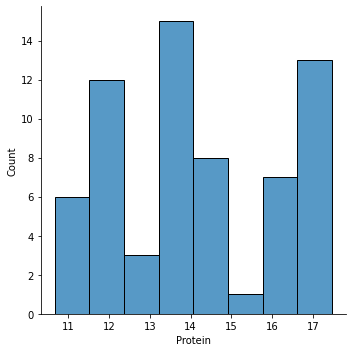

In [70]:
import seaborn as sns
sns.displot(df['Protein'])

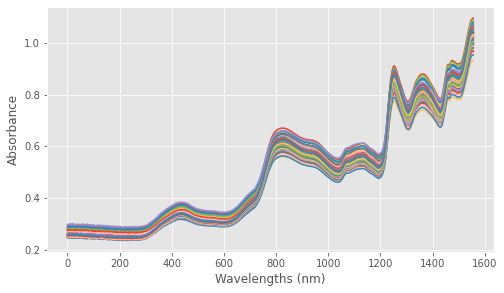

In [71]:
wl = np.arange(0, 1557, 1)
plt.figure(figsize=(8, 4.5))
with plt.style.context('ggplot'):
    plt.plot(wl, df.iloc[:,9:].values.T)
    plt.xlabel("Wavelengths (nm)")
    plt.ylabel("Absorbance")
    plt.show()

In [72]:
##df.iloc[:,9:] = savgol_filter(df.values[:,9:], 3, polyorder=2, deriv=1)
#df.iloc[:,9:] = snv(df.values[:,9:])
df_pretreat = df.iloc[:,9:]
df_pretreat['Umidade'] = df['Moisture']
df_pretreat['Protein'] = df['Protein']
df_pretreat['class'] = df['Protein'].astype(int)

for index, row in df_pretreat.iterrows():
    if row['class']== 15:
        df_pretreat.loc[index, 'class'] = 14
    if row['Protein']< 11.39 and row['Protein']> 11.3:
        df_pretreat.loc[index, 'class'] = 10
    if row['Protein']< 17 and row['Protein']> 16.91:
        df_pretreat.loc[index, 'class'] = 17

df_pretreat

,999.8970106,1000.28298,1000.669047,1001.055413,1001.441976,1001.829039,1002.216201,1002.603862,1002.991623,1003.379885,...,2485.842505,2488.227573,2490.617843,2493.012709,2495.412185,2497.816284,2500.22502,Umidade,Protein,class
0,0.264490,0.265070,0.264313,0.265251,0.264319,0.264963,0.265600,0.265346,0.264630,0.264989,...,1.000223,1.001534,1.001571,1.002851,1.004485,1.004250,1.002066,10.100,13.904338,13
1,0.283164,0.284325,0.283624,0.284148,0.282205,0.281135,0.281490,0.281886,0.282097,0.282473,...,1.037318,1.038840,1.038373,1.038098,1.039568,1.039971,1.039888,8.700,14.786418,14
2,0.276600,0.277441,0.275031,0.276462,0.276817,0.276438,0.276419,0.276996,0.279289,0.279410,...,1.053081,1.054179,1.054097,1.053567,1.053987,1.054386,1.052976,10.400,12.500000,12
3,0.284350,0.286067,0.286507,0.286528,0.286619,0.286029,0.285122,0.286209,0.286949,0.287247,...,1.075393,1.077126,1.075814,1.075846,1.076120,1.076186,1.076950,11.600,14.819005,14
4,0.294623,0.296398,0.297447,0.295038,0.291319,0.292503,0.295399,0.297310,0.297976,0.297869,...,1.013475,1.015025,1.014866,1.015861,1.016620,1.016702,1.016687,10.900,16.722783,16
5,0.282375,0.287083,0.286892,0.284803,0.283465,0.282188,0.284186,0.286474,0.287194,0.286512,...,1.047044,1.049193,1.051013,1.051977,1.051542,1.050629,1.051896,10.800,14.573991,14
6,0.282874,0.284265,0.283478,0.282764,0.282825,0.283858,0.285506,0.286562,0.286818,0.286688,...,1.027949,1.030002,1.029024,1.029246,1.029050,1.030828,1.031243,10.900,16.947250,17
7,0.296397,0.298170,0.298537,0.296517,0.294241,0.295545,0.298439,0.299407,0.300325,0.298181,...,1.090794,1.091733,1.092713,1.094012,1.093522,1.093375,1.094220,10.900,12.008979,12
8,0.287868,0.291356,0.291459,0.290088,0.290191,0.290831,0.292437,0.293254,0.293087,0.292965,...,1.076934,1.077594,1.078698,1.080099,1.080271,1.080195,1.078815,11.800,13.265306,13
9,0.278647,0.280093,0.279433,0.278047,0.277211,0.278076,0.280960,0.282530,0.282205,0.281284,...,1.038255,1.039835,1.040807,1.040020,1.039720,1.040702,1.041183,11.050,14.839798,14


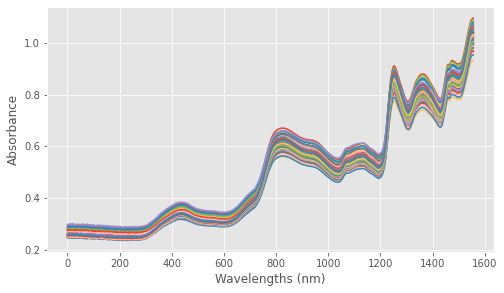

In [73]:
wl = np.arange(0, 1557, 1)
plt.figure(figsize=(8, 4.5))
with plt.style.context('ggplot'):
    plt.plot(wl, df_pretreat.iloc[:,:-3].values.T)
    plt.xlabel("Wavelengths (nm)")
    plt.ylabel("Absorbance")
    plt.show()

In [27]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



pca = PCA(n_components=5)
T = pca.fit_transform(df_pretreat.iloc[:,:-2])
df_pca = pd.DataFrame(T)
df_pca.rename(columns={0: 'PC1', 1: 'PC2', 2: 'PC3', 3: 'PC4', 4: 'PC5'}, inplace=True)

print(pca.explained_variance_ratio_)


[0.88334189 0.06457041 0.02465638 0.01915992 0.00250407]


In [50]:
import plotly.express as px

fig = px.scatter(df_pca, x='PC1', y='PC2', render_mode='svg')

fig.show()

In [74]:
df_pretreat.describe()

,999.8970106,1000.28298,1000.669047,1001.055413,1001.441976,1001.829039,1002.216201,1002.603862,1002.991623,1003.379885,...,2485.842505,2488.227573,2490.617843,2493.012709,2495.412185,2497.816284,2500.22502,Umidade,Protein,class
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,...,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,0.262450,0.263598,0.263188,0.262685,0.262942,0.262787,0.263007,0.262583,0.262511,0.263006,...,1.021549,1.023116,1.023843,1.024174,1.024359,1.024523,1.024243,11.851231,14.114709,13.523077
std,0.013381,0.013966,0.014161,0.013803,0.013159,0.013293,0.013934,0.014699,0.015194,0.014817,...,0.032854,0.032833,0.032685,0.032748,0.032733,0.032808,0.032759,1.358467,2.029961,2.062369
min,0.248124,0.247141,0.246445,0.247026,0.248580,0.248597,0.248738,0.246566,0.246000,0.246762,...,0.928114,0.930028,0.930709,0.930913,0.930114,0.931235,0.932131,8.700000,10.664571,10.000000
25%,0.252859,0.254145,0.254103,0.253420,0.253875,0.254010,0.253906,0.252606,0.251943,0.252630,...,0.999681,1.000850,1.001571,1.002568,1.002324,1.002347,1.001487,11.000000,12.008979,12.000000
50%,0.257334,0.258076,0.257427,0.256755,0.257451,0.257088,0.257091,0.256388,0.255814,0.256028,...,1.024043,1.026266,1.026563,1.027050,1.027214,1.026543,1.025906,11.400000,13.885648,13.000000
75%,0.264490,0.265769,0.265144,0.265251,0.264319,0.265047,0.265600,0.265346,0.264630,0.264989,...,1.045070,1.046475,1.047099,1.047631,1.047026,1.047125,1.048571,11.800000,16.478555,16.000000
max,0.297521,0.300073,0.300032,0.299144,0.299168,0.298542,0.299683,0.300385,0.300661,0.300363,...,1.090794,1.091733,1.092713,1.094012,1.093522,1.093375,1.094220,14.500000,17.463849,17.000000


In [124]:
df_pretreat['class'] = 0
for index, row in df_pretreat.iterrows():
    if row['Protein'] < 12:
        df_pretreat.loc[index, 'class'] = 0
    elif row['Protein'] < 14:
        df_pretreat.loc[index, 'class'] = 1
    elif row['Protein'] < 16:
        df_pretreat.loc[index, 'class'] = 2
    else:
        df_pretreat.loc[index, 'class'] = 3

In [135]:
#SNV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


y = df_pretreat[['Umidade','Protein','class']]
## Do not take the reference value and the class
X = df_pretreat.values[:, :-2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0,stratify=y['class'])


col = [1,2,4,5,8,25,28,29,30,31,33,34,39,41,43,44,46,48,52,55,56,59,60,67,68,72,73,75,78,81,83,84,90,91,93,94,98,103,104,109,117,118,120,121,123,124,127,129,130,138,142,144,146,147,154,157,158,160,163,165,166,168,171,176,177,180,184,188,193,194,196,198,201,206,209,212,214,215,216,219,220,226,228,230,236,240,241,242,243,245,251,252,253,254,256,257,264,266,271,272,274,276,283,285,291,292,295,297,298,300,301,308,310,311,317,318,321,324,328,329,332,341,343,344,346,348,354,355,359,366,370,371,374,376,378,383,384,385,387,388,389,391,393,394,398,400,404,405,406,410,411,412,416,417,423,424,425,426,428,429,433,440,443,444,445,446,447,453,456,457,460,462,465,466,471,472,473,474,479,480,481,483,484,485,488,489,490,492,493,494,498,504,506,507,510,513,514,515,516,518,520,521,531,533,536,537,539,540,541,547,552,553,554,556,558,564,568,569,573,574,575,576,577,580,582,586,592,593,594,596,597,598,601,604,607,608,610,613,617,618,620,625,628,634,636,639,640,641,642,644,646,647,654,659,660,661,663,665,669,670,671,675,676,677,678,681,682,688,691,692,696,697,698,701,705,706,712,713,718,719,722,724,725,726,729,737,738,739,741,745,746,749,750,752,754,762,763,773,774,778,781,784,785,786,787,791,792,794,797,799,800,801,805,809,812,815,816,823,825,826,828,833,834,835,836,844,847,848,849,851,853,863,870,874,876,877,878,879,882,883,888,889,890,892,893,894,895,899,902,904,906,922,930,934,935,936,938,941,944,946,949,950,951,953,955,956,958,960,961,966,967,970,974,975,978,980,983,985,987,995,999,1000,1001,1002,1004,1006,1012,1014,1015,1016,1022,1024,1027,1031,1032,1033,1035,1038,1039,1040,1046,1047,1048,1050,1051,1053,1054,1059,1063,1064,1065,1067,1068,1072,1073,1074,1075,1076,1077,1078,1082,1085,1087,1089,1090,1091,1092,1094,1099,1101,1103,1104,1105,1107,1108,1110,1111,1113,1117,1119,1120,1124,1128,1129,1134,1135,1139,1140,1144,1147,1151,1152,1153,1154,1156,1157,1159,1160,1161,1164,1165,1166,1169,1172,1179,1180,1184,1189,1191,1192,1196,1199,1201,1208,1209,1211,1213,1214,1215,1216,1220,1223,1225,1226,1229,1230,1239,1241,1243,1250,1252,1255,1259,1263,1266,1279,1280,1282,1286,1289,1291,1292,1293,1298,1301,1304,1306,1307,1309,1312,1314,1316,1318,1319,1321,1324,1325,1327,1330,1332,1333,1337,1339,1341,1344,1346,1350,1351,1353,1359,1361,1362,1365,1368,1369,1371,1373,1376,1378,1379,1380,1381,1385,1388,1390,1392,1394,1397,1398,1401,1402,1403,1405,1406,1411,1416,1417,1421,1425,1426,1430,1431,1439,1440,1443,1446,1452,1453,1455,1458,1461,1468,1469,1471,1473,1474,1479,1480,1483,1484,1488,1491,1492,1496,1497,1501,1505,1507,1508,1509,1513,1515,1516,1521,1524,1525,1527,1529,1533,1535,1537,1538,1541,1543,1544,1545,1546,1550,1551,1552,1555,1556]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))
col=[0,2,3,7,14,15,21,22,23,25,32,35,39,40,56,59,63,65,66,67,68,69,73,76,77,80,85,90,91,93,96,98,99,101,106,108,109,113,114,116,120,131,136,138,139,143,145,146,148,152,155,157,158,162,163,165,167,169,171,172,175,178,181,182,185,187,188,189,190,191,196,198,199,202,206,209,219,223,224,225,227,228,232,236,240,245,247,251,252,253,257,265,274,276,277,279,282,283,285,286,290,292,293,297,303,308,309,316,317,319,321,324,327,331,334,335,337,340,342,343,346,347,349,353,354,355,356,357,360,362,363,365,367,368,371,375,377,381,383,389,399,407,408,413,415,416,418,422,423,424,434,436,437,438,439,442,444,449,455,456,457,458,459,460,461,463,466,468,470,474,475,477,478,481,482,485,488,489,493,499,500,505,506,507,510,513,517,519,522,525,526,527,532,533,535,537,538,542,543,546,550,551,558,567,571,574,577,578,582,585,587,590,591,593,594,601,602,605,606,610,611,612,616,621,622,624,626,627,630,632,634,637,638,639,640,641,642,643,646,647,651,653,654,655,657,666,667,668,672,676,678,679,683,684,688,692,696,700,701,710,713,715,718,721,723,724,725,726,727,732,733,734,735,737,740,746,748,749,750,751,753,754,759,760,761,762,764,765,771,772,776,777,778,786,788,790,791,792,799,800,801,802,805,808,809,810,811,812,813,815,816,817,827,830,837,838,842,845,846,853,855,857,861,862,863,866,867,868,875,878,881,882,886,891,892,893,894,896,899,903,905,916,921,922,924,927,928,930,931,933,935,938,940,941,942]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [   1,   5,   6,   7,   8,  11,  12,  13,  16,  17,  18,  20,  22,
        28,  31,  33,  37,  39,  41,  44,  46,  49,  53,  56,  59,  62,
        63,  68,  74,  79,  81,  92,  97,  98, 100, 106, 107, 110, 111,
       122, 123, 124, 128, 129, 131, 132, 134, 144, 146, 150, 152, 155,
       160, 161, 162, 164, 168, 170, 178, 179, 180, 183, 187, 190, 193,
       197, 199, 200, 201, 214, 221, 227, 228, 232, 244, 245, 246, 248,
       250, 254, 259, 260, 262, 266, 268, 269, 270, 273, 275, 277, 282,
       286, 290, 293, 296, 298, 300, 301, 306, 310, 312, 313, 318, 319,
       320, 324, 327, 330, 332, 335, 337, 341, 345, 346, 347, 348, 349,
       352, 354, 356, 358, 362, 364, 366, 367, 368, 374, 376, 377, 382,
       384, 386, 389, 390, 391, 396, 397, 398, 400, 401, 407, 408, 410,
       411, 419, 420, 421, 429, 431, 435, 436, 437, 440, 442, 443, 444,
       448, 451, 456, 458, 465, 469, 470, 471, 477, 480, 488, 489, 495,
       496, 498, 499, 501, 508, 510, 514, 515, 526, 527, 538, 542, 547,
       552, 553, 554, 555, 557, 562, 563, 565, 568, 571, 572, 574, 575,
       577, 580, 581, 583, 584]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

# col = [  1,   2,   3,   5,   8,  10,  13,  14,  16,  20,  27,  28,  29,
#         36,  39,  41,  47,  53,  56,  59,  60,  62,  63,  65,  67,  76,
#         79,  94,  95,  96,  99, 100, 102, 116, 120, 121, 123, 126, 132,
#        133, 134, 140, 146, 150, 163, 168, 170, 175, 176, 178, 181, 182,
#        183, 187, 191, 193, 195, 201, 202, 204, 211, 212, 214, 216, 219,
#        221, 223, 228, 231, 232, 233, 234, 235, 238, 240, 244, 247, 250,
#        252, 253, 256, 266, 273, 278, 280, 284, 287, 288, 289, 291, 296,
#        297, 299, 302, 306, 307, 308, 313, 315, 319, 320, 327, 329, 331,
#        335, 336, 342, 345, 347, 348, 353, 357, 358, 365, 367, 369, 372,
#        373, 375, 376, 381, 385, 390]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# #X_train_snv = msc(X_train)
# #X_test_snv = msc(X_test)

y_train_oleo = y_train['Protein']


y_test_oleo = y_test['Protein']

#X1 = savgol_filter(X_train, 23, polyorder=2, deriv=2)
#X2 = savgol_filter(X_test, 23, polyorder=2, deriv=2)

# X_train_snv = msc(X_train)
# X_test_snv = msc(X_test)

# mean centre correction
#X_mc = mc(X1)

##Standard Normal Variate

# Xsnv = snv(X_train)

In [75]:
#SNV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


y = df_pretreat[['Umidade','Protein','class']]
## Do not take the reference value and the class
X = df_pretreat.values[:, :-3]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0,stratify=y['class'])


# col = [0,1,2,4,6,7,8,9,11,12,13,15,17,20,23,25,26,27,28,29,33,34,35,36,41,43,44,46,47,50,51,55,61,65,66,68,72,76,77,78,80,83,85,88,90,92,94,95,96,97,101,104,113,115,116,121,123,126,131,132,133,136,140,142,145,149,151,155,160,164,167,170,172,176,182,185,186,188,190,192,194,196,200,201,205,206,209,210,214,218,221,222,223,232,233,234,236,241,242,243,244,248,249,250,251,252,253,255,257,264,265,266,269,270,271,273,274,278,279,280,286,289,301,305,307,309,311,312,313,315,317,320,324,325,329,331,334,335,338,339,341,342,343,345,349,351,353,357,358,360,361,365,367,368,373,376,377,380,385,386,387,388,391,392,393,397,403,407,408,412,430,431,439,440,444,448,449,450,451,456,459,460,463,464,465,467,470,471,473,474,477,479,483,486,487,488,490,493,494,495,496,498,503,505,506,510,512,515,517,518,519,522,523,525,529,531,532,533,534,536,537,539,540,541,544,545,549,551,553,554,556,563,566,567,568,571,575,576,577,578,580,582,583,586,587,592,593,595,598,601,604,605,606,610,614,618,620,625,628,629,634,636,639,640,644,646,647,648,651,652,653,654,656,657,660,662,667,669,671,675,678,684,690,691,694,695,696,697,698,699,701,709,710,713,717,721,723,727,730,732,734,735,736,737,740,745,753,755,757,761,762,764,768,770,772,773,774,779,780,784,791,795,797,798,801,802,805,806,809,811,813,816,820,821,824,825,828,829,834,839,841,842,843,845,847,851,854,855,856,859,861,863,864,865,868,871,872,873,878,879,880,882,886,888,891,893,894,895,897,899,905,909,913,916,920,923,924,925,932,935,936,937,938,941,944,947,948,949,950,951,952,954,958,960,961,962,963,964,965,979,992,993,994,995,997,1000,1001,1002,1004,1005,1006,1007,1008,1009,1013,1015,1018,1024,1028,1036,1037,1038,1043,1044,1045,1050,1052,1055,1057,1058,1060,1061,1066,1067,1068,1069,1071,1073,1076,1080,1083,1084,1087,1089,1091,1097,1098,1104,1108,1113,1114,1115,1118,1119,1120,1121,1122,1123,1125,1126,1128,1130,1131,1135,1136,1139,1141,1148,1153,1158,1160,1162,1164,1165,1166,1172,1173,1175,1176,1181,1183,1185,1186,1188,1195,1197,1200,1202,1203,1204,1207,1211,1213,1214,1218,1219,1221,1223,1224,1225,1226,1229,1230,1231,1232,1233,1234,1240,1243,1246,1248,1249,1251,1253,1258,1259,1260,1264,1271,1276,1279,1280,1281,1283,1284,1286,1288,1289,1295,1296,1297,1299,1303,1304,1305,1306,1310,1311,1314,1315,1316,1317,1319,1320,1321,1325,1332,1335,1337,1342,1345,1347,1350,1356,1357,1358,1360,1362,1365,1367,1369,1372,1374,1376,1379,1380,1381,1389,1391,1396,1409,1410,1413,1414,1415,1416,1420,1421,1423,1426,1433,1437,1440,1443,1444,1446,1448,1457,1458,1459,1460,1464,1466,1470,1471,1473,1478,1480,1481,1482,1483,1484,1490,1492,1493,1495,1501,1502,1506,1511,1517,1525,1529,1530,1535,1536,1537,1540,1541,1547,1548,1550,1551,1552,1553,1554,1556]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# col=[1,   6,   9,  10,  11,  15,  16,  17,  18,  19,  23,  31,  35,
#         38,  39,  45,  49,  50,  51,  56,  59,  61,  62,  65,  67,  68,
#         70,  71,  72,  73,  77,  78,  79,  83,  84,  90,  91,  92,  97,
#         99, 100, 102, 103, 106, 110, 111, 114, 115, 116, 117, 119, 121,
#        122, 123, 124, 127, 131, 132, 134, 135, 136, 137, 138, 139, 142,
#        144, 145, 148, 149, 150, 151, 153, 154, 155, 156, 160, 161, 165,
#        172, 173, 175, 179, 183, 184, 185, 186, 189, 190, 191, 194, 198,
#        199, 205, 213, 214, 216, 217, 221, 222, 224, 225, 226, 227, 229,
#        230, 236, 242, 243, 247, 250, 251, 255, 258, 260, 261, 262, 264,
#        266, 267, 269, 270, 274, 275, 277, 280, 290, 291, 292, 293, 296,
#        300, 304, 310, 311, 313, 314, 316, 317, 323, 324, 328, 329, 331,
#        335, 336, 337, 343, 345, 349, 352, 354, 355, 356, 357, 359, 360,
#        361, 363, 366, 368, 370, 373, 374, 382, 390, 391, 392, 394, 395,
#        396, 398, 399, 400, 405, 411, 413, 416, 417, 418, 420, 422, 424,
#        425, 427, 428, 429, 432, 433, 437, 442, 444, 450, 451, 454, 458,
#        460, 464, 468, 469, 471, 475, 477, 482, 486, 489, 490, 492, 499,
#        501, 503, 504, 506, 507, 510, 513, 515, 516, 518, 522, 525, 527,
#        528, 537, 538, 539, 542, 547, 549, 550, 551, 552, 554, 556, 557,
#        559, 560, 562, 567, 571, 574, 576, 582, 583, 585, 586, 588, 595,
#        600, 601, 604, 605, 606, 610, 621, 623, 624, 627, 632, 633, 639,
#        643, 644, 645, 649, 654, 656, 659, 663, 664, 665, 668, 670, 671,
#        675, 676, 679, 680, 685, 688, 691, 697, 698, 699, 701, 703, 707,
#        715, 719, 721, 733, 735, 738, 741, 745, 747, 749, 757, 759, 761,
#        766, 767, 769, 771, 772, 773, 778, 779, 781, 784, 787, 789, 804,
#        811, 813, 814, 815, 817, 821, 822, 826, 828, 830, 833, 840, 852,
#        853, 854, 855, 856, 859, 861, 862, 863, 864, 866, 867, 868, 872,
#        873, 876, 879, 881, 882, 884, 886, 887, 894, 895, 896, 897, 899,
#        901, 903, 904, 905, 910, 912, 917, 922, 925, 927]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))

# col = [  3,   5,  10,  13,  18,  20,  21,  22,  25,  27,  28,  31,  35,
#         37,  39,  43,  47,  48,  60,  62,  63,  65,  66,  68,  75,  80,
#         81,  85,  87,  91,  95, 100, 101, 118, 119, 120, 121, 122, 125,
#        126, 136, 137, 139, 142, 147, 151, 154, 159, 160, 164, 166, 167,
#        170, 176, 177, 187, 189, 195, 198, 199, 201, 206, 207, 210, 211,
#        213, 214, 221, 228, 233, 234, 236, 237, 248, 253, 255, 259, 265,
#        267, 269, 270, 272, 274, 276, 279, 280, 283, 284, 288, 289, 290,
#        291, 294, 297, 301, 303, 304, 306, 309, 311, 312, 314, 319, 320,
#        321, 322, 323, 326, 329, 331, 336, 338, 339, 340, 345, 347, 349,
#        350, 352, 356, 360, 361, 365, 366, 368, 371, 376, 379, 385, 388,
#        389, 392, 398, 400, 406, 409, 417, 418, 421, 431, 439, 441, 443,
#        444, 446, 450, 456, 458, 461, 463, 465, 469, 472, 473, 475, 477,
#        481, 487, 488, 491, 500, 501, 506, 507, 509, 511, 512, 513, 519,
#        520, 528, 529, 531, 533, 539, 540, 541, 542, 543, 544, 545, 546,
#        547, 548, 551, 556, 557, 559, 560, 561, 563, 565, 567, 568]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))

# # # col = [ 0,   9,  11,  12,  13,  15,  18,  23,  24,  27,  31,  33,  35,
# # #         36,  37,  39,  40,  42,  43,  45,  48,  49,  58,  61,  66,  70,
# # #         73,  75,  79,  81,  84,  87,  89,  90, 104, 106, 108, 111, 112,
# # #        113, 121, 123, 128, 136, 138, 140, 141, 145, 146, 148, 149, 155,
# # #        157, 160, 162, 165, 167, 169, 171, 173, 175, 177, 178, 179, 180,
# # #        183, 188, 197, 198, 205, 212, 213, 219, 224, 225, 227, 229, 230,
# # #        231, 233, 239, 243, 249, 252, 256, 257, 262, 264, 266, 271, 272,
# # #        281, 287, 288, 289, 291, 292, 293, 295, 296, 299, 300, 302, 312,
# # #        316, 319, 330, 332, 334, 335, 336, 339, 341, 346, 349, 373]
# # # X_train = (np.delete(X_train, col,1))
# # # X_test = (np.delete(X_test, col,1))


# # ################
# col = [  2,   8,  10,  11,  12,  15,  27,  32,  33,  34,  35,  40,  41,
#         42,  43,  44,  52,  53,  54,  55,  60,  62,  65,  68,  69,  71,
#         75,  78,  79,  80,  82,  86,  88,  93,  94,  96,  99, 104, 113,
#        117, 126, 129, 132, 134, 136, 137, 143, 147, 150, 153, 155, 157,
#        158, 164, 165, 174, 175, 178, 184, 187, 188, 194, 198, 201, 203,
#        204, 206, 211, 215, 219, 226, 228, 232, 235, 238, 239, 241, 247,
#        248, 255, 259, 261, 262, 263, 265, 268, 276, 277, 279, 281, 284,
#        288, 289, 294, 300, 303, 305, 307, 310, 311, 312, 316, 318, 321,
#        322, 325, 326, 329, 332, 333, 334, 338, 339, 342, 344, 346, 349,
#        352, 355, 357, 360, 361, 364, 365, 367, 374]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))

# col = [ 0,   4,   7,  10,  18,  22,  31,  33,  37,  39,  40,  41,  43,
#         48,  50,  51,  52,  56,  58,  60,  63,  64,  70,  71,  73,  74,
#         79,  81,  95, 100, 110, 111, 113, 115, 118, 119, 120, 122, 125,
#        129, 130, 131, 133, 135, 137, 139, 154, 156, 164, 165, 166, 167,
#        168, 171, 173, 183, 184, 189, 190, 197, 202, 206, 216, 223, 224,
#        234, 235, 237, 243, 244, 245]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))

# col = [  3,  12,  22,  24,  30,  32,  44,  47,  49,  52,  56,  57,  64,
#         67,  68,  70,  74,  76,  80,  81,  89,  93,  94,  96,  97, 106,
#        107, 109, 112, 118, 119, 125, 132, 140, 141, 151, 155, 164, 165,
#        173, 175]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))


#######################
# col = [  4,   9,  10,  16,  17,  22,  23,  25,  36,  37,  38,  39,  43,
#         49,  51,  54,  61,  62,  69,  70,  72,  78,  81,  85,  92,  93,
#         95, 102, 105, 106, 120, 127, 128, 133, 136, 140, 141, 143, 147,
#        158, 168, 172, 174, 178, 183, 185, 188, 193, 194, 201, 205, 206,
#        208, 211, 212, 214, 217, 224, 239, 240, 244, 245, 249, 252, 254,
#        255, 258]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))

# col = [  3,   8,  15,  16,  25,  26,  27,  34,  38,  39,  48,  49,  50,
#         52,  55,  61,  62,  63,  65,  68,  79,  85,  94, 100, 102, 108,
#        109, 111, 114, 120, 121, 123, 126, 128, 132, 135, 136, 145, 150,
#        151, 153, 161, 168, 170, 176, 178, 183, 188, 189]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))

# col = [  2,   8,  15,  23,  26,  32,  35,  37,  38,  44,  48,  54,  58,
#         59,  61,  63,  79,  84,  86,  89,  93,  95,  97, 104, 107, 112,
#        121, 133, 138]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))

# #X_train_snv = msc(X_train)
# #X_test_snv = msc(X_test)

y_train_oleo = y_train['Protein']


y_test_oleo = y_test['Protein']

#X1 = savgol_filter(X_train, 23, polyorder=2, deriv=2)
#X2 = savgol_filter(X_test, 23, polyorder=2, deriv=2)

# X_train_snv = msc(X_train)
# X_test_snv = msc(X_test)

# mean centre correction
#X_mc = mc(X1)

##Standard Normal Variate

# Xsnv = snv(X_train)

In [76]:
# #Derive

# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split


# y = df_pretreat[['Umidade','Protein','class']]
# ## Do not take the reference value and the class
# X = df_pretreat.values[:, :-2]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0,stratify=y['class'])


# col = [1,2,10,11,12,15,17,18,20,21,22,26,27,28,32,34,36,39,40,42,46,48,49,53,59,62,63,65,66,67,69,71,73,74,75,79,80,82,86,87,88,89,90,94,95,96,97,98,100,101,103,105,106,110,114,116,117,118,119,120,121,122,123,125,128,130,133,134,137,140,142,143,146,147,148,149,151,154,155,156,158,160,162,163,167,171,173,176,177,179,180,182,184,185,188,189,193,194,195,196,197,201,204,205,208,209,211,212,213,214,216,217,219,221,222,223,225,226,227,231,233,234,239,241,245,247,250,252,253,254,255,256,258,259,263,266,267,269,270,272,273,275,276,279,280,282,283,284,285,286,287,289,290,293,294,295,297,301,302,305,306,308,310,315,318,321,322,327,328,331,337,338,339,340,341,343,344,345,347,348,350,351,352,355,360,361,362,363,367,368,370,373,374,377,380,385,386,387,390,393,394,395,399,403,407,409,411,416,417,418,420,421,422,423,428,429,430,431,434,436,439,441,442,446,447,448,458,461,463,464,465,467,471,473,475,476,479,481,482,483,489,491,494,495,499,500,501,505,506,512,514,515,516,521,523,524,525,526,529,533,536,537,538,539,540,545,547,548,552,557,558,563,564,567,569,570,571,572,574,578,579,581,582,583,585,586,587,588,590,593,597,598,599,601,602,603,605,606,607,608,611,612,613,614,615,617,618,619,620,622,623,629,630,631,632,633,636,641,645,646,648,651,653,655,656,657,661,663,665,666,667,668,670,672,676,677,682,685,687,688,690,692,693,694,696,698,702,705,707,710,712,713,715,722,723,724,726,727,728,729,730,732,734,737,738,739,741,744,745,746,747,748,749,752,754,755,757,760,761,762,763,766,767,768,769,770,772,773,776,778,781,786,789,790,793,794,795,796,797,799,807,808,809,810,812,813,818,820,822,823,826,828,829,831,832,833,835,836,838,839,840,843,844,846,847,849,850,856,857,858,859,861,863,864,866,870,873,879,880,881,882,883,887,890,893,895,897,898,899,901,903,904,906,909,911,913,914,915,916,920,922,924,929,931,932,938,941,942,943,946,947,953,955,959,965,967,968,969,972,973,975,977,978,979,980,981,982,983,985,986,988,989,993,994,999,1003,1006,1010,1011,1012,1013,1014,1015,1016,1017,1019,1020,1022,1024,1026,1027,1030,1031,1032,1036,1037,1039,1042,1043,1044,1047,1048,1049,1055,1056,1059,1060,1061,1063,1068,1069,1070,1076,1077,1079,1085,1086,1091,1092,1095,1096,1097,1098,1101,1103,1104,1110,1111,1114,1115,1116,1119,1121,1122,1125,1130,1131,1134,1135,1136,1137,1144,1147,1150,1151,1154,1155,1156,1158,1161,1162,1163,1164,1168,1170,1171,1173,1174,1176,1178,1179,1181,1183,1185,1187,1192,1195,1197,1198,1199,1202,1204,1205,1206,1208,1209,1210,1214,1215,1217,1221,1222,1228,1232,1234,1235,1236,1239,1240,1241,1243,1244,1246,1249,1252,1253,1254,1257,1258,1259,1261,1262,1266,1267,1268,1269,1271,1275,1277,1279,1280,1282,1286,1289,1290,1291,1292,1294,1295,1296,1298,1301,1303,1304,1305,1310,1314,1315,1319,1320,1322,1323,1324,1331,1337,1342,1343,1345,1356,1360,1362,1364,1365,1366,1368,1369,1371,1374,1378,1380,1388,1392,1394,1400,1402,1403,1405,1407,1411,1412,1413,1414,1417,1418,1420,1422,1424,1430,1433,1434,1436,1441,1445,1447,1449,1450,1455,1456,1459,1460,1462,1464,1466,1471,1472,1473,1477,1481,1486,1487,1488,1490,1492,1494,1495,1499,1500,1502,1505,1506,1508,1511,1512,1516,1518,1520,1522,1523,1528,1530,1532,1533,1534,1535,1538,1539,1541,1542,1543,1544,1545,1546,1547,1548,1549,1551,1553,1554,1555]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# col=[2,4,5,6,8,9,14,15,16,17,21,25,26,27,29,30,31,33,34,35,37,39,40,41,43,44,46,47,48,53,54,56,58,60,61,66,70,71,73,75,76,77,80,82,85,86,87,88,89,93,94,95,96,97,100,102,103,105,106,108,109,115,118,120,121,122,123,124,126,127,128,129,133,136,140,141,143,144,145,147,150,151,152,156,157,161,162,163,164,165,166,169,170,171,172,175,176,177,179,180,181,182,183,184,188,189,190,191,192,193,194,198,199,200,201,202,206,209,213,218,219,221,223,226,227,228,231,232,234,235,236,238,239,242,247,248,249,255,256,257,258,260,261,263,268,270,272,275,276,278,280,281,283,284,285,290,292,295,297,299,300,301,305,307,308,309,310,312,313,317,318,324,326,327,328,330,332,333,334,336,338,340,343,344,347,350,352,353,358,359,363,366,370,373,374,376,379,380,381,383,384,389,390,393,394,397,398,399,400,402,403,404,405,410,411,412,413,415,416,417,418,419,420,423,424,425,427,428,429,431,432,433,434,436,437,443,444,445,446,447,448,449,450,452,454,455,457,461,463,464,466,468,469,470,472,474,475,480,481,485,488,494,496,498,499,505,507,511,515,516,517,518,519,520,523,524,526,532,533,534,535,538,539,540,542,545,547,548,549,552,554,558,559,562,563,565,566,567,568,569,571,582,584,585,586,588,590,591,592,594,598,599,600,601,602,603,605,610,613,614,615,622,623,624,629,630,631,633,634,636,637,642,645,647,650,652,653,655,656,657,658,659,660,661,667,668,669,671,675,676,678,679,681,684,688,689,691,693,694,700,703,704,705,708,711,712,715,726,729,730,732,733,734,735,736,737,738,739,741,742,745,746,749,750,751,752,754,756,757,758,762,763,764,765,768,769,772,779,780,781,784,788,794,795,796,798,799,801,803,804,806,807]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))

# col = [   0,   1,   6,   8,  10,  12,  13,  14,  16,  19,  20,  22,  25,
#         33,  34,  35,  37,  41,  43,  44,  49,  50,  51,  53,  57,  58,
#         59,  60,  61,  62,  68,  69,  70,  71,  76,  79,  81,  83,  85,
#         89,  99, 100, 102, 103, 105, 107, 109, 111, 114, 115, 117, 118,
#        121, 125, 127, 128, 134, 136, 138, 142, 147, 149, 152, 160, 161,
#        162, 165, 168, 170, 172, 173, 174, 175, 179, 181, 182, 188, 189,
#        192, 196, 198, 200, 202, 205, 206, 210, 214, 219, 220, 225, 226,
#        228, 233, 236, 238, 239, 243, 245, 246, 258, 259, 264, 272, 273,
#        274, 275, 276, 277, 278, 280, 281, 282, 283, 284, 287, 288, 290,
#        291, 298, 300, 301, 302, 303, 304, 305, 306, 307, 312, 313, 314,
#        319, 321, 327, 328, 333, 334, 335, 337, 339, 342, 354, 356, 362,
#        363, 364, 367, 373, 376, 377, 381, 382, 383, 385, 386, 388, 390,
#        391]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))

# col = [  0,   5,   8,  10,  12,  14,  19,  20,  27,  28,  29,  31,  34,
#         35,  36,  38,  41,  44,  47,  49,  53,  55,  59,  60,  66,  71,
#         73,  75,  76,  78,  79,  80,  82,  83,  85,  88,  90,  91,  92,
#         96,  99, 100, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
#        114, 116, 117, 119, 120, 121, 122, 131, 132, 134, 135, 139, 142,
#        144, 145, 149, 152, 153, 155, 157, 159, 161, 163, 174, 175, 177,
#        181, 182, 184, 187, 190, 191, 200, 216, 219, 220, 222, 224, 226,
#        227, 229, 234, 235, 238]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# # X_train_snv = msc(X_train)
# # X_#test_snv = msc(X_test)

# y_train_oleo = y_train['Protein']


# y_test_oleo = y_test['Protein']

# #X1 = savgol_filter(X_train, 23, polyorder=2, deriv=2)
# #X2 = savgol_filter(X_test, 23, polyorder=2, deriv=2)

# # X_train_snv = msc(X_train)
# # X_test_snv = msc(X_test)

# # mean centre correction
# #X_mc = mc(X1)

# ##Standard Normal Variate

# # Xsnv = snv(X_train)

In [77]:
X_train.shape

(48, 1557)

In [78]:
len(X_test)

17

In [112]:
# Import PySwarms
import pyswarms as ps

# Initialize swarm, arbitrary
options = {'c1': 2, 'c2': 2, 'w':0.9, 'k': 20, 'p':2}

# Call instance of PSO
dimensions = X_train.shape[1] # dimensions should be the number of features

optimizer = ps.discrete.BinaryPSO(n_particles=20, dimensions=dimensions, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f, iters=100, verbose=2)
optimizer.reset()

2023-05-02 22:48:13,707 - pyswarms.discrete.binary - INFO - Optimize for 100 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 20, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|100/100, best_cost=0.0336
2023-05-02 22:59:00,790 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.03362729743074012, best pos: [1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1
 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 0 1
 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1]


In [113]:
np.where(pos == 0)[0]

array([  3,  12,  22,  24,  30,  32,  44,  47,  49,  52,  56,  57,  64,
        67,  68,  70,  74,  76,  80,  81,  89,  93,  94,  96,  97, 106,
       107, 109, 112, 118, 119, 125, 132, 140, 141, 151, 155, 164, 165,
       173, 175], dtype=int64)

In [34]:
with open("Col_to_delete_2023-05-02_Wheat_protein_snv.txt", "w") as txt_file:
    for line in np.where(pos == 0)[0]:
        txt_file.write(str(line)+',')

In [79]:
ls_score_pls = []
n_opt = 8
for i in range(3,9):
    pls_simple = PLSRegression(n_components=i)
    cv = LeaveOneOut()
    #cv = 10

    X1 = X_train 
    #X1 = X_train[:,pos==1] 

    X2 = X_test
    #X2 = X_test[:,pos==1] 


    # Fit
    pls_simple.fit(X1, y_train_oleo)


    # Cross-validation
    y_cv = cross_val_predict(pls_simple,X1, y_train_oleo, cv=cv)
    y_pred = pls_simple.predict(X2)
    score = r2_score(y_train_oleo, y_cv)
    if ls_score_pls:
        if score< ls_score_pls[-1] and i>4:
            n_opt =  i-1
            break

    ls_score_pls.append(score)

pls_simple = PLSRegression(n_components=n_opt)
cv = LeaveOneOut()
#cv = 10

X1 = X_train 
#X1 = X_train[:,pos==1] 

X2 = X_test
#X2 = X_test[:,pos==1] 


# Fit
pls_simple.fit(X1, y_train_oleo)


# Cross-validation
y_cv = cross_val_predict(pls_simple,X1, y_train_oleo, cv=cv)
y_pred = pls_simple.predict(X2)
# Calculate scores
score = r2_score(y_train_oleo, y_cv)
score_train = mean_squared_error(y_train_oleo, y_cv,squared=False)
score_test = mean_squared_error(y_test_oleo, y_pred,squared=False)

print('N comp: ', n_opt)
print('N W: ', X_train.shape)
print('R2: ', score)
print('RMSE train: ', score_train)
print('RMSE test: ', score_test)



N comp:  8
N W:  (48, 1557)
R2:  0.9730691183381993
RMSE train:  0.33581403086577055
RMSE test:  0.2550783010389887


Sans suppression 
N comp:  7
R2:  0.9805049598710649
RMSE train:  0.27595271220778406
RMSE test:  0.29009266827183483

1e boucle
N comp:  7
R2:  0.9831982207456885
RMSE train:  0.2561829589026026
RMSE test:  0.2708269216645377

2e boucle
N comp:  6
R2:  0.9849831044939732
RMSE train:  0.24219360940939957
RMSE test:  0.24730487643536805

3e
N comp:  9
R2:  0.9872025093580399
RMSE train:  0.22358105982604698
RMSE test:  0.24924251365465772

4e
N comp:  6
R2:  0.9871519526637231
RMSE train:  0.2240222548198685
RMSE test:  0.2706374693677986


Derive

1e boucle
N comp:  7
R2:  0.8443729298212104
RMSE train:  0.7796778041725819
RMSE test:  1.083202000891111

2e
N comp:  13
R2:  0.9101503934267089
RMSE train:  0.5924213344224807
RMSE test:  1.0363557918297595

3e
N comp:  8
R2:  0.9395854758358158
RMSE train:  0.48578408187061634
RMSE test:  1.060057150000316

4e
N comp:  11
R2:  0.9714393086793586
RMSE train:  0.3340080684002813
RMSE test:  1.0016505154741253

5e
N comp:  9
R2:  0.9798866100697079
RMSE train:  0.28029492643100534
RMSE test:  1.0098700715421522


#SNV

N comp:  8
R2:  0.9845619593655333
RMSE train:  0.2542550817211081
RMSE test:  0.22318440525892122

N comp:  8
R2:  0.9883433226181755
RMSE train:  0.22093317833785509
RMSE test:  0.201607787570438

N comp:  8
R2:  0.988921366527693
RMSE train:  0.21538559242737057
RMSE test:  0.19260607186134462

N comp:  8
R2:  0.9895243700304294
RMSE train:  0.20944192779975856
RMSE test:  0.19678730656074378

N comp:  8
R2:  0.9925122082001334
RMSE train:  0.17707221994772723
RMSE test:  0.19580215924773092

N comp:  8
R2:  0.9917799074532182
RMSE train:  0.1855290434741453
RMSE test:  0.22682561777188678









N comp:  8
R2:  0.9916223155864788
RMSE train:  0.18729903947888898
RMSE test:  0.23294941574822697

N comp:  8
R2:  0.9934466069265414
RMSE train:  0.16565580559936982
RMSE test:  0.2606671582280617

N comp:  8
R2:  0.9922277228893237
RMSE train:  0.18040463450474412
RMSE test:  0.26607241270279025

In [64]:
import plotly.express as px

df_pred = pd.DataFrame()
df_pred['y_ref_train'] = y_train_oleo
df_pred['y_pred_train'] = y_cv
fig = px.scatter(df_pred, x="y_ref_train", y="y_pred_train", trendline="ols", title="Prediction performance for protein content ",
                 labels={
                     "y_ref_train": "Protein content measured (%)",
                     "y_pred_train": "Protein content predicted (%)",

                 },width=600, height=400)
fig.show()

In [65]:
df_pred = pd.DataFrame()
df_pred['y_ref_test'] = y_test_oleo
df_pred['y_pred_test'] = y_pred
fig = px.scatter(df_pred, x="y_ref_test", y="y_pred_test", trendline="ols", title="Prediction performance for protein content ",
                 labels={
                     "y_ref_test": "Protein content measured (%)",
                     "y_pred_test": "Protein content predicted (%)",

                 },width=600, height=400)
fig.show()